<a href="https://colab.research.google.com/github/gulssumm/first_ML_project/blob/main/ML_Project_Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'books-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4200521%2F7250132%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240916%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240916T101623Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dac1bbcb7ede65f5ebf706c80d66ef2d9f8fbca0d552e037271e09d05f28a95a2bfc7e0818f0fa68d3ce40a3d57c6f60e1a0b6cebe6a466bfe8e791490c8759be230683053e1aeeba99349c11deca9eef33e639f70842d33bf366fce65ca20a8b61e59aa7f0c109a779a0285b99473658310d82ca46718d02a2b2a129facc5be791682984b9ab5a0ecbb4c070507db0355c85c3fb57e3583ba19e8e652b42a9205e6fd2007c6e456fef5d0b767c4b37e306e6dd82656de26c48dca393efe6b3a4aacb406bc687133e6b0932f6c4fb9dafd11230522ed6934ad88da29ad4464affd5ee0dc3affc0a98a220a2224aa3a02311a228926b6a25fe80ef92abb10e6914'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 55469565 bytes downloaded
Downloaded and uncompressed: books-dataset
Data source import complete.


In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/books-dataset/BooksDatasetClean.csv
/kaggle/input/books-dataset/BooksDataset.csv


In [17]:
df = pd.read_csv("/kaggle/input/books-dataset/BooksDataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103082 entries, 0 to 103081
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Title         103082 non-null  object
 1   Authors       103082 non-null  object
 2   Description   70213 non-null   object
 3   Category      76912 non-null   object
 4   Publisher     103074 non-null  object
 5   Publish Date  103082 non-null  object
 6   Price         103082 non-null  object
dtypes: object(7)
memory usage: 5.5+ MB


In [18]:
df.head()

,Title,Authors,Description,Category,Publisher,Publish Date,Price
0,Goat Brothers,"By Colton, Larry",NaN,"History , General",Doubleday,"Friday, January 1, 1993",Price Starting at $8.79
1,The Missing Person,"By Grumbach, Doris",NaN,"Fiction , General",Putnam Pub Group,"Sunday, March 1, 1981",Price Starting at $4.99
2,Don't Eat Your Heart Out Cookbook,"By Piscatella, Joseph C.",NaN,"Cooking , Reference",Workman Pub Co,"Thursday, September 1, 1983",Price Starting at $4.99
3,When Your Corporate Umbrella Begins to Leak: A...,"By Davis, Paul D.",NaN,NaN,Natl Pr Books,"Monday, April 1, 1991",Price Starting at $4.99
4,Amy Spangler's Breastfeeding : A Parent's Guide,"By Spangler, Amy",NaN,NaN,Amy Spangler,"Saturday, February 1, 1997",Price Starting at $5.32


In [19]:
df.columns

Index(['Title', 'Authors', 'Description', 'Category', 'Publisher',
       'Publish Date', 'Price'],
      dtype='object')

In [20]:
df.isnull().sum()            # Check if there is null objects on dataset

,0
Title,0
Authors,0
Description,32869
Category,26170
Publisher,8
Publish Date,0
Price,0


In [21]:
# Fill missing 'Description', 'Category', and 'Publisher' with 'Unknown'
df['Description'].fillna('Unknown', inplace=True)
df['Category'].fillna('Unknown', inplace=True)
df['Publisher'].fillna('Unknown', inplace=True)

In [22]:
df.isnull().sum()

,0
Title,0
Authors,0
Description,0
Category,0
Publisher,0
Publish Date,0
Price,0


# Unsupervised Learning

* Text descriptions of the books (like the 'Description' column) are converted into numerical form using a technique called TF-IDF (Term Frequency-Inverse Document Frequency). This creates numerical vectors that represent the importance of words in each description
* Other features like price are directly numeric, so they can be used as it is.

* After have that the numeric features for each book:
    * Apply K-Means to group the books  into clusters
    * Assign each book a cluster number



In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.cluster import KMeans

# Encode categorical features
label_encoders = {}
for column in ['Authors', 'Category', 'Publisher']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Extract numeric part of Price (assuming 'Price Starting at $5.29' format)
# df['Price'] = df['Price'].str.extract(r'(\d+\.\d+)').astype(float)

# Convert 'Description' text to TF-IDF vectors
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
description_vectors = tfidf.fit_transform(df['Description'].fillna(''))

# Combine features like price, category (use one-hot encoding)
features = pd.concat([pd.DataFrame(description_vectors.toarray()), df[['Price']].fillna(0)], axis=1)

# Ensure all column names are strings
features.columns = features.columns.astype(str)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(features)

# Add clusters to the DataFrame
df['Cluster'] = clusters

# Print cluster assignment
print(df[['Title', 'Cluster']].head())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                               Title  Cluster
0                                      Goat Brothers        0
1                                 The Missing Person        0
2                  Don't Eat Your Heart Out Cookbook        0
3  When Your Corporate Umbrella Begins to Leak: A...        0
4    Amy Spangler's Breastfeeding : A Parent's Guide        0


### PCA(Principal Component Analysis)

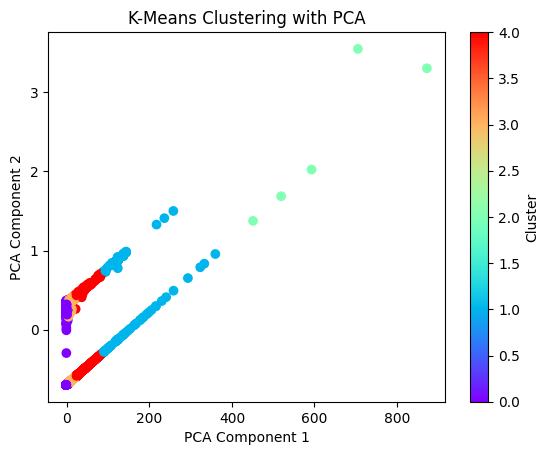

In [30]:
from sklearn.decomposition import PCA        # It helps reduce the data to 2D
import matplotlib.pyplot as plt

# Apply PCA to reduce the features to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
# fit_transform(features) applies the PCA transformation to features dataset

# Plot the PCA-reduced features
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis') # cmap adds a color map
plt.title('K-Means Clustering with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

### Deduction
* Each point represent a book
* The position of the points is bassed on their transformed features(after PCA)
* The color of the points shows which cluter each book belongs to
* Points close to each other in the plot are more similar, while points far apart (like those near 800 on the x-axis) are likely outliers or belong to a different group of books based on the features you selected.

# Improvement

In [31]:
# Group by cluster and check the number of books in each cluster
cluster_groups = df.groupby('Cluster')
print(cluster_groups.size())

# Example: View the first few books in Cluster 0
cluster_0_books = df[df['Cluster'] == 0]
print(cluster_0_books[['Title', 'Authors', 'Category', 'Price']].head())

Cluster
0    90958
1      161
2        5
3    11271
4      687
dtype: int64
                                               Title  Authors  Category  Price
0                                      Goat Brothers    11518      1038   8.79
1                                 The Missing Person    23169       758   4.99
2                  Don't Eat Your Heart Out Cookbook    45671       485   4.99
3  When Your Corporate Umbrella Begins to Leak: A...    13798      3106   4.99
4    Amy Spangler's Breastfeeding : A Parent's Guide    54159      3106   5.32


In [32]:
# Compute the average price of books in each cluster
avg_price_per_cluster = df.groupby('Cluster')['Price'].mean()
print(avg_price_per_cluster)

# View the most common categories in each cluster
common_categories_per_cluster = df.groupby('Cluster')['Category'].apply(lambda x: x.value_counts().head(3))
print(common_categories_per_cluster)

Cluster
0      5.479300
1    141.395466
2    635.076000
3     12.861532
4     41.240087
Name: Price, dtype: float64
Cluster      
0        3106    21112
         758      2280
         774      1608
1        3106       70
         835         5
         758         5
2        3106        4
         2102        1
3        3106     4542
         758       244
         780       220
4        3106      442
         758        20
         780        18
Name: Category, dtype: int64
